In [1]:
import os
import re
import copy
import cv2
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2

DATA_DIR = "/home/ec2-user/word_level_ocr/pritom/datasets/"

In [2]:
synthetic_imgs = os.listdir(os.path.join(DATA_DIR, "synthetic_words/train"))
print(len(synthetic_imgs))

2074992


In [3]:
class SynthDataset(Dataset):
    def __init__(self, img_dir, transform=None):

        self.img_dir = img_dir
        self.inp_h = 32
        self.inp_w = 128
        self.img_names = sorted(os.listdir(img_dir), key=lambda x: int(x.split('.')[0]))
        self.transform = transform

    def __len__(self):
        return len(self.img_names)

    def __getitem__(self, idx):
        img_name = self.img_names[idx]
        # print(img_name)
        image = cv2.imread(os.path.join(self.img_dir, img_name))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        img_h, img_w = image.shape
        image = cv2.resize(image, (0,0), fx=self.inp_w / img_w, fy=self.inp_h / img_h, interpolation=cv2.INTER_CUBIC)
        #print(image.shape)
        image = np.reshape(image, (self.inp_h, self.inp_w, 1))
        #print(image.shape)

        if self.transform is not None:
            image = self.transform(image = image)["image"]
            return image, img_name, idx
            
        image = image.transpose(2, 0, 1)
        #print(image.shape)
        
        return image, img_name, idx

In [4]:
##Albumentations noise
data_transform = A.Compose([    
    
    # Pixel level noise
    A.OneOf([
        # GaussNoise -> Random grainy noise
        A.GaussNoise (var_limit=(120.0, 135.0), mean=0, per_channel=True, always_apply=False, p=0.33),
        # PixelDropout -> Salt-and-pepper noise
        A.PixelDropout (dropout_prob=0.005, per_channel=False, drop_value=0, mask_drop_value=None, always_apply=False, p=0.33),
        # ElasticTransform -> used for Pencilic effect
        A.ElasticTransform (alpha=0.15, sigma=0, alpha_affine=0, interpolation=1, border_mode=4, value=None, mask_value=None, always_apply=False, approximate=False, same_dxdy=False, p=0.33),
       ], p=0.3),
    
    # Geometric transformations
    A.OneOf([
        # Perspective -> Change the viewing perspective
        A.Perspective (scale=(0.05, 0.05), keep_size=True, pad_mode=0, pad_val=0, mask_pad_val=0, fit_output=False, interpolation=1, always_apply=False, p=0.5),
        # Rotate -> Randomly rotate the image up to the limit
        A.Rotate (limit=5, interpolation=1, border_mode=4, value=None, mask_value=None, always_apply=False, p=0.5),
       ], p=0.3),
    
    # Brightness, Contrast and Blur
    A.OneOf([
        # RandomBrightnessContrast -> Randomly increases and decreases the brightness of the picture up to limit
        A.RandomBrightnessContrast (brightness_limit=[-0.5, 0.5], contrast_limit=[-0.5, 0.5], brightness_by_max=True, always_apply=False, p=0.5),
        # Motion Blur -> Self Explanatory
        A.MotionBlur(blur_limit=(3, 6), p=0.5),
       ], p=0.2),
    
    ToTensorV2(),
    ])

In [5]:
ocr_dataset = SynthDataset(os.path.join(DATA_DIR, "synthetic_words/train"), transform=data_transform)

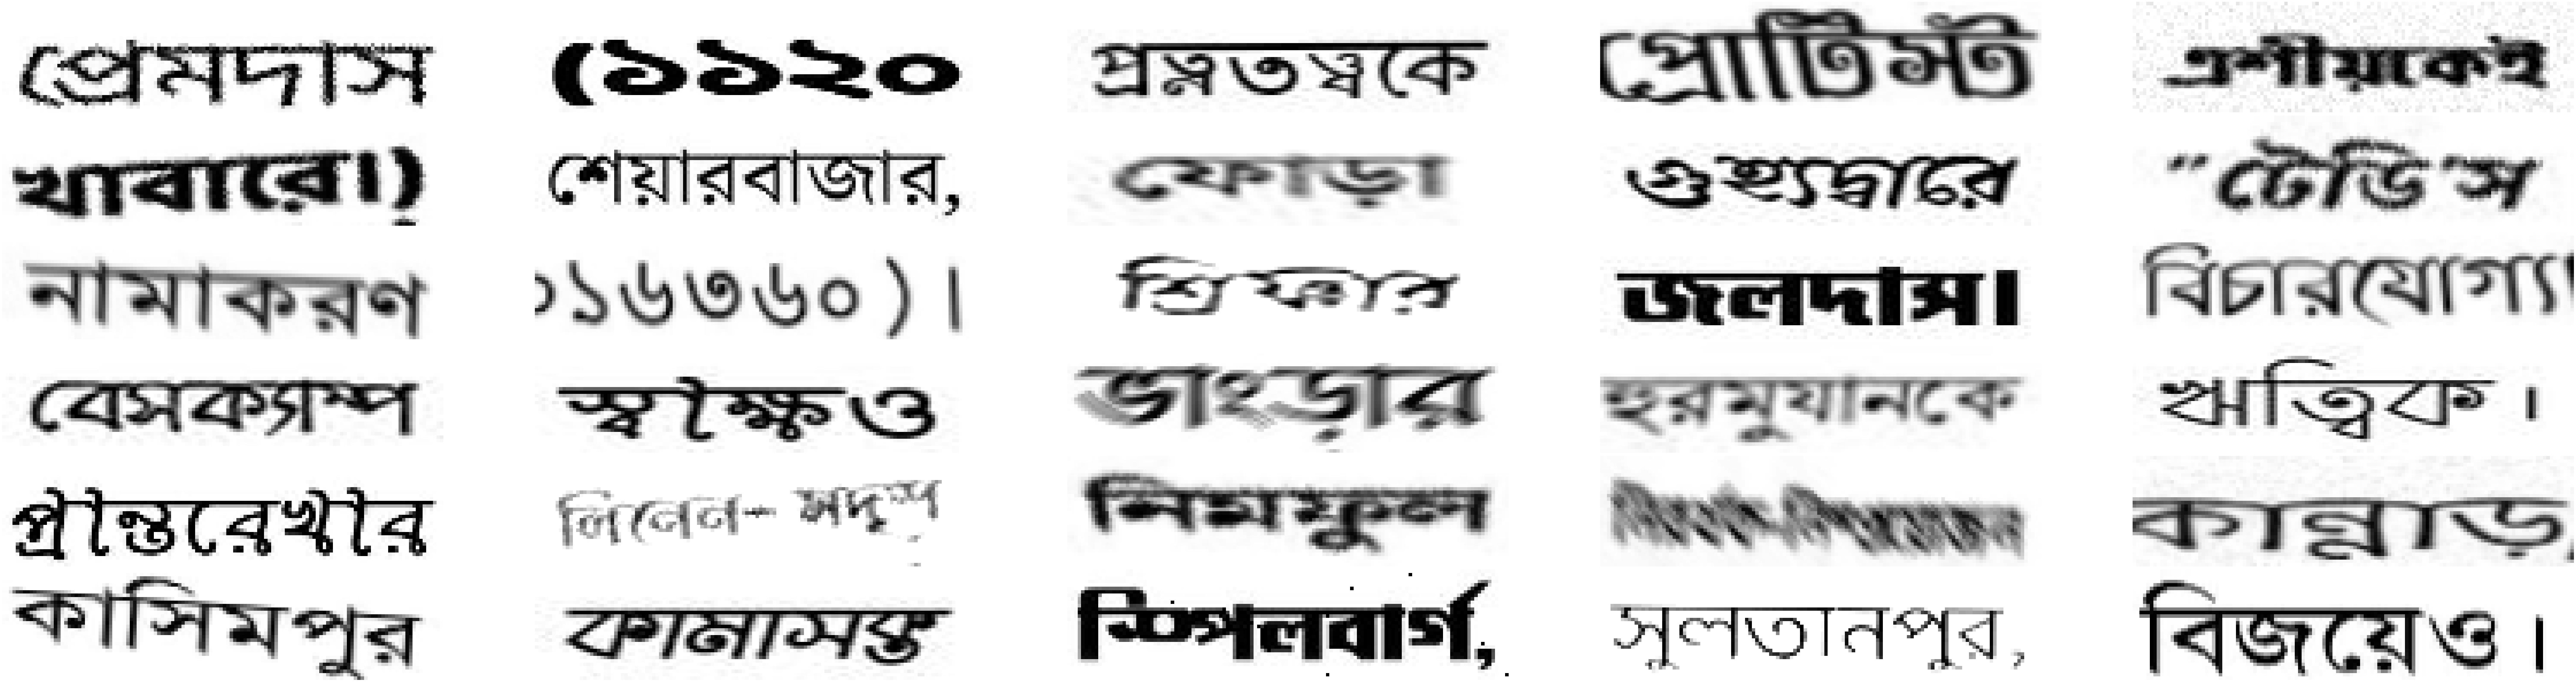

In [6]:
#visualizing augmentations
def visualize_augmentations(dataset, idx=100000, samples=30, cols=5):
    dataset = copy.deepcopy(dataset)
    dataset.transform = A.Compose([t for t in dataset.transform if not isinstance(t, (A.Normalize, ToTensorV2))])
    
    rows = samples // cols
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(128,32))
    for i in range(samples):
        #print(len(dataset[idx]))
        #print(dataset[idx])
    
        image, _, _ = dataset[idx]

        #print(image.shape)
        image = np.squeeze(image, axis=(2,) )
        ax.ravel()[i].imshow(image, cmap='gray')
        ax.ravel()[i].set_axis_off()
        idx += 1
        
    plt.tight_layout()
    plt.show()

visualize_augmentations(ocr_dataset)

In [92]:
def normalize_word(word):

#     if 'ো' in word:
#         word = word.replace('ো', 'ো')
    
#     if 'ৌ' in word:
#         word = word.replace('ৌ', 'ৌ')  

    if '়' in word:
        new_word = []
        length = len(word)
        for i in range(0, length):
            if word[i] == '়':
                if word[i-1] == 'ব':
                    new_word[-1] = 'র'
                elif word[i-1] == 'য':
                    new_word[-1] = 'য়'
                elif word[i-1] == 'ড':
                    new_word[-1] = 'ড়'
                elif word[i-1] == 'ঢ':
                    new_word[-1] = 'ঢ়'
                else:
                    new_word.append(word[i])
            else:
                new_word.append(word[i])

        word = ''.join([str(i) for i in new_word])
    
    return word
    
########################Version 4#################################################################
def extract_graphemes(word):
    
    forms_cluster = {'ক': ['ক', 'ট', 'ত', 'ন', 'ব', 'ম', 'র', 'ল', 'ষ', 'স'],
                     'গ': ['গ', 'ধ', 'ন', 'ব', 'ম', 'ল'],
                     'ঘ': ['ন'],
                     'ঙ': ['ক', 'খ', 'গ', 'ঘ', 'ম'],
                     'চ': ['চ', 'ছ', 'ঞ'],
                     'জ': ['জ', 'ঝ', 'ঞ', 'ব'],
                     'ঞ': ['চ', 'ছ', 'জ', 'ঝ'],
                     'ট': ['ট', 'ব'],
                     'ড': ['ড'],
                     'ণ': ['ট', 'ঠ', 'ড', 'ঢ', 'ণ', 'ব', 'ম'],
                     'ত': ['ত', 'থ', 'ন', 'ব', 'ম', 'র'],
                     'থ': ['ব'],
                     'দ': ['গ', 'ঘ', 'দ', 'ধ', 'ব', 'ভ', 'ম'],
                     'ধ': ['ন', 'ব'],
                     'ন': ['জ', 'ট', 'ঠ', 'ড', 'ত', 'থ', 'দ', 'ধ', 'ন', 'ব', 'ম', 'স'],
                     'প': ['ট', 'ত', 'ন', 'প', 'ল', 'স'],
                     'ফ': ['ট', 'ল'],
                     'ব': ['জ', 'দ', 'ধ', 'ব', 'ভ', 'ল'],
                     'ভ': ['র'],
                     'ম': ['ন', 'প', 'ফ', 'ব', 'ভ', 'ম', 'ল'],
                     'ল': ['ক', 'গ', 'ট', 'ড', 'প', 'ফ', 'ব', 'ম', 'ল', 'স'],
                     'শ': ['চ', 'ছ', 'ত', 'ন', 'ব', 'ম', 'ল'],
                     'ষ': ['ক', 'ট', 'ঠ', 'ণ', 'প', 'ফ', 'ব', 'ম'],
                     'স': ['ক', 'খ', 'ট', 'ত', 'থ', 'ন', 'প', 'ফ', 'ব', 'ম', 'ল'],
                     'হ': ['ণ', 'ন', 'ব', 'ম', 'ল'],
                     'ড়': ['গ']}
    
    forms_tripple_cluster = {'ক্ষ': ['ণ', 'ম'], 'ঙ্ক': ['ষ'], 'চ্ছ': ['ব'], 'জ্জ': ['ব'],
                             'ত্ত': ['ব'], 'দ্দ': ['ব'], 'দ্ধ': ['ব'], 'দ্ভ': ['র'],
                             'ন্ত': ['ব'], 'ন্দ': ['ব'], 'ম্প': ['ল'], 'ম্ভ': ['র'],
                             'ষ্ক': ['র'], 'স্ক': ['র'], 'স্ত': ['ব', 'র'], 'স্প': ['ল']}
    
    chars = []
    i = 0
    adjust = 0
    
    while(i < len(word)):
        if i+1 < len(word) and word[i+1] == '্':
            if word[i] == 'র':
                chars.append('র্')
                adjust = 0
                i+=2
            elif i+2 < len(word) and word[i+2] == 'য':
                chars.append(word[i-adjust:i+1])
                chars.append('্য')
                adjust = 0
                i+=3
            elif i+2 < len(word) and word[i+2] == 'র':
                # Treat '্র' as a seperate grapheme
                chars.append(word[i-adjust:i+1])
                chars.append('্র')
                # Keep '্র' icluded in the cluster
                # chars.append(word[i-adjust:i+3])
                if i+3 < len(word) and word[i+3] == '্' and i+4 < len(word) and word[i+4] == 'য':    
                    chars.append('্য')
                    i+=5
                else:
                    i+=3
                adjust = 0
            elif i+2 < len(word) and adjust!=0 and word[i-adjust:i+1] in forms_tripple_cluster \
                and word[i+2] in forms_tripple_cluster[word[i-adjust:i+1]]:
                if i+3 < len(word) and word[i+3] == '্':
                    adjust += 2
                    i+=2
                else:
                    chars.append(word[i-adjust:i+3])
                    adjust = 0
                    i+=3
            elif i+2 < len(word) and adjust==0 and word[i] in forms_cluster and word[i+2] in forms_cluster[word[i]]:
                if i+3 < len(word) and word[i+3] == '্':
                    adjust += 2
                    i+=2
                else:
                    chars.append(word[i-adjust:i+3])
                    adjust = 0
                    i+=3
            else:
                chars.append(word[i-adjust:i+1])
                chars.append('্')
                adjust = 0
                i+=2

        else:
            chars.append(word[i:i+1])
            i+=1

    
    #print(word)
    #print(chars)

    return chars

#Break every character
# def extract_graphemes(word):
    
#     return list(word)


In [23]:
synth12 = "/home/ec2-user/word_level_ocr/pritom/datasets/out_50000_Synthetic_controlled_12lakh"

filenames = os.listdir(synth12)
filenames = sorted(filenames, key=lambda x: int(x.split('_')[0]))

wordlist = []

for i, name in tqdm(enumerate(filenames)):
    wordlist.append(name.split('_')[1][:-4])

1199984it [00:01, 1079409.98it/s]


In [25]:
grapheme_dict = {}

for word in wordlist:
    graphemes = extract_graphemes(normalize_word(word))
    for grapheme in graphemes:
        try:
            grapheme_dict[grapheme] += 1
        except KeyError:
            grapheme_dict[grapheme] = 1

print(len(grapheme_dict))
grapheme_list = sorted(grapheme_dict.items(), key=lambda x:x[1], reverse=True)
grapheme_dict = dict(grapheme_list)
print(grapheme_dict)
print()
print(sorted(grapheme_dict))

341
{'া': 1050058, 'ে': 599074, 'ি': 549506, 'র': 537760, 'ন': 346186, 'ক': 318394, 'ব': 277518, 'ল': 275010, 'ম': 250496, 'স': 226056, 'ু': 225454, 'ত': 219336, 'প': 197562, 'য়': 190058, 'ট': 146174, 'ো': 141608, 'দ': 139752, 'গ': 126844, 'ই': 121920, '্র': 117828, 'হ': 115894, 'জ': 115116, 'ী': 111528, 'শ': 108804, '্য': 97262, 'র্': 82282, 'ভ': 75234, 'ও': 73316, 'চ': 72480, 'আ': 61592, 'ড়': 60208, '।': 53584, 'অ': 51794, 'ছ': 48910, 'খ': 47846, 'ফ': 47596, 'ড': 44692, 'এ': 42542, 'উ': 40204, ',': 39558, 'ধ': 38368, 'ণ': 36498, 'ং': 34674, '-': 31734, 'য': 29332, 'ঁ': 28104, 'ূ': 25756, 'থ': 24820, '—': 23880, '’': 21702, 'ষ': 21148, '১': 20602, 'ঘ': 20132, '‘': 19838, 'ৃ': 19258, 'ন্দ': 18628, 'ন্ত': 18586, 'ক্ষ': 17516, '০': 15716, '২': 14332, 'স্ট': 12572, 'ঙ্গ': 12164, 'স্ত': 11624, 'ঠ': 11168, 'ক্ত': 10714, ')': 9596, '৩': 9588, 'ন্ট': 9498, '.': 9456, 'ঝ': 9388, '৫': 9318, 'ন্ড': 9152, '(': 8982, 'ৌ': 8842, 'ষ্ট': 8466, '৪': 8410, 'স্ব': 8328, 'ত্ত': 8284, 'ৈ': 7990, 'স্থ': 76

In [36]:
labels_train = pd.read_csv("/home/ec2-user/word_level_ocr/pritom/datasets/apurba_printed/march_snap/new_csvs/typewriter_march_train_no_nokta.csv")
labels_test = pd.read_csv("/home/ec2-user/word_level_ocr/pritom/datasets/apurba_printed/march_snap/new_csvs/typewriter_march_test_no_nokta.csv")

In [40]:
wordlist_train = []
wordlist_test = []

for i in tqdm(range(len(labels_train))):
    wordlist_train.append(labels_train.iloc[i]['Word'].strip())

for i in tqdm(range(len(labels_test))):
    wordlist_test.append(labels_test.iloc[i]['Word'].strip())

100%|██████████| 6765/6765 [00:00<00:00, 7404.88it/s]


In [41]:
grapheme_train = {}

for word in wordlist_train:
    graphemes = extract_graphemes(normalize_word(word))
    for grapheme in graphemes:
        try:
            grapheme_train[grapheme] += 1
        except KeyError:
            grapheme_train[grapheme] = 1

print(len(grapheme_train))
grapheme_list = sorted(grapheme_train.items(), key=lambda x:x[1], reverse=True)
grapheme_train = dict(grapheme_list)
print(grapheme_train)
print()
print(sorted(grapheme_train))

179
{'া': 19623, 'র': 10786, 'ি': 9764, 'ন': 8482, 'ে': 8396, 'ক': 7262, 'ব': 5629, 'স': 5110, 'ত': 5101, 'ম': 4986, 'প': 4858, 'ল': 4702, 'য়': 3353, 'দ': 3260, 'হ': 3048, 'ী': 2953, 'জ': 2808, 'ু': 2335, '্র': 2326, 'গ': 2011, '্য': 1986, 'ো': 1936, 'র্': 1935, 'ং': 1821, 'অ': 1613, 'ই': 1587, 'শ': 1534, 'আ': 1484, 'ট': 1263, 'এ': 1256, 'ঃ': 1158, 'খ': 1101, 'ড': 1060, 'চ': 1059, 'য': 968, 'ধ': 950, 'ভ': 912, 'ও': 895, 'উ': 887, ',': 709, 'ছ': 654, 'থ': 621, 'স্থ': 618, 'ফ': 605, 'স্ব': 534, 'ন্ত': 477, 'ণ': 459, 'ড়': 452, 'ক্ষ': 449, 'ৃ': 421, '-': 395, 'ষ': 383, 'ূ': 356, 'ঢ': 347, 'ক্ত': 295, ' ': 240, 'স্ত': 238, 'ল্প': 235, 'ন্ট': 230, '১': 228, 'ষ্ট': 221, 'ৎ': 200, 'প্ত': 198, 'ত্ত': 180, 'দ্দ': 179, 'ঞ্জ': 173, '২': 159, 'ঠ': 158, 'ন্ন': 152, 'ম্প': 146, 'দ্ধ': 138, 'ঘ': 136, '০': 127, 'ৌ': 126, '৯': 121, 'ল্ল': 119, 'ন্দ': 118, '৮': 110, 'স্ম': 108, 'ঁ': 107, '(': 94, 'ৈ': 93, '৫': 88, 'জ্ঞ': 87, '৩': 86, 'ত্ব': 77, '৭': 76, '৪': 74, ')': 71, '।': 67, 'ম্ন': 66, 'ন্স': 65, 'ঐ

In [42]:
grapheme_test = {}

for word in wordlist_test:
    graphemes = extract_graphemes(normalize_word(word))
    for grapheme in graphemes:
        try:
            grapheme_test[grapheme] += 1
        except KeyError:
            grapheme_test[grapheme] = 1

print(len(grapheme_test))
grapheme_list = sorted(grapheme_test.items(), key=lambda x:x[1], reverse=True)
grapheme_test = dict(grapheme_list)
print(grapheme_test)
print()
print(sorted(grapheme_test))

150
{'া': 4061, 'র': 2211, 'ি': 2031, 'ন': 1754, 'ে': 1689, 'ক': 1519, 'ব': 1214, 'স': 1067, 'ত': 1054, 'ম': 1028, 'প': 1002, 'ল': 914, 'য়': 692, 'দ': 670, 'ী': 629, 'হ': 614, 'জ': 592, '্র': 513, 'ু': 473, 'ো': 419, '্য': 418, 'গ': 402, 'র্': 390, 'ং': 373, 'অ': 346, 'ই': 320, 'শ': 306, 'আ': 302, 'ট': 272, 'ঃ': 254, 'এ': 243, 'চ': 243, 'ড': 241, 'ধ': 227, 'ও': 217, 'উ': 199, 'খ': 193, 'য': 192, 'ভ': 173, 'ছ': 147, 'থ': 140, 'স্থ': 139, 'ফ': 127, ',': 116, 'ক্ষ': 113, 'ন্ত': 106, 'ড়': 102, 'স্ব': 95, 'ণ': 95, 'ৃ': 85, '-': 81, 'ঢ': 75, 'ক্ত': 67, 'ষ': 66, 'স্ত': 62, 'ূ': 58, '১': 52, 'ল্প': 48, '০': 46, 'ষ্ট': 45, ' ': 42, 'প্ত': 41, 'দ্দ': 40, 'ৎ': 38, '২': 36, 'ঞ্জ': 33, 'স্ম': 33, 'ৌ': 32, 'ন্ট': 32, 'ঘ': 31, 'ত্ত': 31, 'ম্প': 31, 'ঠ': 28, '৪': 27, 'ল্ল': 25, 'দ্ধ': 25, 'ন্ন': 24, '৮': 23, 'ন্দ': 22, '(': 22, '।': 18, '৩': 18, 'জ্ঞ': 16, '৯': 15, 'ঁ': 15, 'ম্ম': 15, '৫': 15, 'ৈ': 15, 'শ্ব': 14, 'প্ল': 14, ')': 13, 'ম্ন': 13, '৭': 12, 'ষ্ঠ': 12, 'ত্ব': 12, 'শ্ল': 11, 'ম্ব': 11, 'স্ক'

In [34]:
diff = set(sorted(grapheme_test)) - set(sorted(grapheme_train))
print(diff)

{'গ্ব', 'ন্ত্ব'}


In [35]:
diff = set(sorted(grapheme_test)) - set(sorted(grapheme_dict))
print(diff)

{'!', ' ', '?'}


In [29]:
# initializing string
test_str = ' '
  
# printing original String
print("The original string is : " + str(test_str))
  
# using sub() to perform substitutions
# ord() for conversion.
res = (re.sub('.', lambda x: r'\u % 04X' % ord(x.group()), test_str))
  
# printing result 
print("The unicode converted String : " + str(res))

The original string is :  
The unicode converted String : \u  020
